In [15]:
using Convex
using ECOS
using LinearAlgebra, SparseArrays

using Plots
pyplot()

using BenchmarkTools

Need to make the variable, objective, and constraints. First, the variable

In [2]:
N = 40 # Steps on Trajectory
num_controls = 3 # ux, uy, uz
num_states = 6 # x, y, z, vx, vy, vz

var_size = N * (num_controls + num_states) + num_states # Last step does not have a control

tau = Variable(var_size) # Trajectory

Variable
size: (366, 1)
sign: real
vexity: affine
id: 957…534

In [7]:
Q = 0.025 * Diagonal(I, num_states)
R = 0.25 * Diagonal(I, num_controls);

In [17]:
# Initialize and empty sparse array
QRFull = spzeros(var_size, var_size)

rStart = 1

# Put Q and R along the diagonal
for k in 1:N
    rEnd = rStart + QSize - 1
    QRFull[rStart:rEnd, rStart:rEnd] = Q

    rStart += QSize
    rEnd = rStart + RSize - 1

    QRFull[rStart:rEnd, rStart:rEnd] = R

    rStart += RSize
end
rEnd = rStart + QSize - 1
QRFull[rStart:rEnd, rStart:rEnd] = Q;

  2.136 ms (3243 allocations: 250.94 KiB)


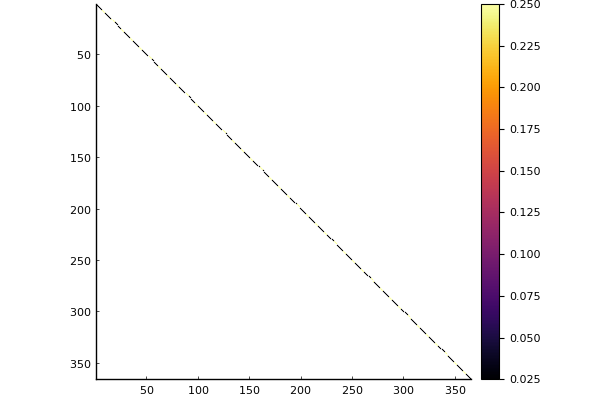

In [16]:
@btime spy(QRFull)

In [61]:
# Set the Objective Function to the problem
problem = minimize(quadform(tau, QRFull ./ 2))

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]

status: `solve!` not called yet

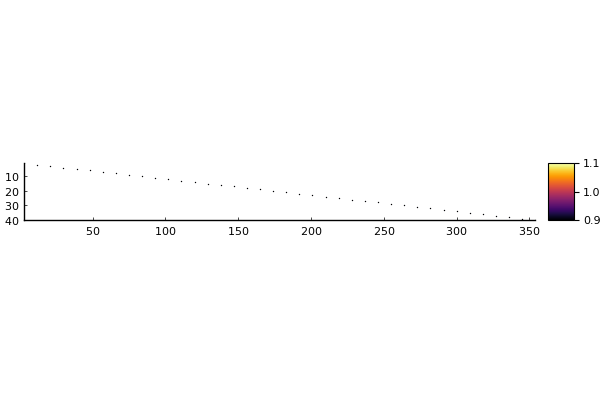

In [64]:
# Add the Ground Constraint
ground_mat = spzeros(var_size, var_size)

currInd = 3
currRow = 1
while currRow <= N
    ground_mat[currRow, currInd] = 1

    currRow += 1
    currInd += 3 * Int(num_states / 2)
end

problem.constraints += ground_mat * tau > 0

spy(ground_mat)

In [65]:
solve!(problem, ECOS.Optimizer)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.322e+00  +4e+02  9e-01  3e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -8.725e-02  -1.339e-01  +3e+01  9e-02  2e-02  1e-01  9e-02  0.9288  2e-02   1  1  1 |  0  0
 2  -5.182e-03  -7.931e-03  +2e+00  5e-03  1e-03  6e-03  6e-03  0.9384  1e-04   1  1  1 |  0  0
 3  -3.561e-03  -6.326e-03  +1e+00  7e-03  6e-04  4e-03  4e-03  0.8619  6e-01   1  2  2 |  0  0
 4  -1.101e-03  -2.481e-03  +8e-01  3e-03  2e-04  1e-03  2e-03  0.4832  2e-01   1  2  2 |  0  0
 5  +1.126e-04  -4.710e-04  +5e-01  9e-04  7e-05  3e-04  1e-03  0.5399  4e-01   1  1  2 |  0  0
 6  -2.867e-04  -5.805e-04  +3e-01  5e-04  3e-05  2e-04  8e-04  0.9754  6e-01   1  1  1 |  0  0
 7  +2.070e-05  -7.737e-05  +1e-01  9e-05  7e-06  1e-06  3e-04  0.7620  2e-01   1  2  2 |  0  0
 8  +1.927e-06  -1.333e-05  +2e-02  1e-05  1e-

In [66]:
display(problem.optval)
display(evaluate(tau))
problem

1.3787803470410614e-12

366-element Array{Float64,1}:
 0.0
 0.0
 2.2694126666484256e-6
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 2.2694126666484256e-6
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
└─ >= constraint (affine)
   ├─ * (affine; real)
   │  ├─ 366×366 SparseMatrixCSC{Float64,Int64}
   │  └─ 366-element real variable (id: 957…534)
   └─ 0

termination status: OPTIMAL
primal status: FEASIBLE_POINT
dual status: FEASIBLE_POINT

In [71]:
x = Variable(2)

Variable
size: (2, 1)
sign: real
vexity: affine
id: 142…402

In [75]:
# problem = minimize(4 * x, [x > 0])
problem = minimize(quadform(x, [4 0; 0 4]), [x[1] == 3])

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
└─ == constraint (affine)
   ├─ index (affine; real)
   │  └─ 2-element real variable (id: 142…402)
   └─ 3

status: `solve!` not called yet

In [76]:
solve!(problem, ECOS.Optimizer)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.322e+00  +1e+01  5e-01  8e-02  1e+00  4e+00    ---    ---    1  1  - |  -  - 
 1  +4.153e+00  +6.390e+00  +3e+00  4e-01  4e-02  3e+00  8e-01  0.9890  2e-01   1  1  1 |  0  0
 2  +1.126e+01  +1.792e+01  +7e-01  4e-01  3e-02  8e+00  2e-01  0.9890  3e-01   1  1  1 |  0  0
 3  +2.004e+01  +2.208e+01  +2e-01  8e-02  7e-03  2e+00  5e-02  0.7978  7e-02   2  1  1 |  0  0
 4  +1.959e+01  +2.737e+01  +1e-01  3e-01  1e-02  8e+00  3e-02  0.6775  5e-01   2  2  2 |  0  0
 5  +3.181e+01  +3.269e+01  +2e-02  3e-02  2e-03  9e-01  5e-03  0.9890  1e-01   2  1  1 |  0  0
 6  +3.580e+01  +3.586e+01  +1e-03  2e-03  1e-04  6e-02  3e-04  0.9427  9e-04   2  1  1 |  0  0
 7  +3.599e+01  +3.599e+01  +4e-05  6e-05  4e-06  2e-03  1e-05  0.9633  1e-04   2  1  1 |  0  0
 8  +3.600e+01  +3.600e+01  +2e-06  3e-06  2e-

In [77]:
display(problem.optval)
display(evaluate(x))
problem

35.99999989349313

2-element Array{Float64,1}:
 2.9999999999797784
 0.0

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
└─ == constraint (affine)
   ├─ index (affine; real)
   │  └─ 2-element real variable (id: 142…402)
   └─ 3

termination status: OPTIMAL
primal status: FEASIBLE_POINT
dual status: FEASIBLE_POINT

In [101]:
Q = Symmetric([6 5; 0 8])
p = [4; -3]
x = Variable(2)
problem = minimize(quadform(x, Q ./ 2) + p'x)

minimize
└─ + (convex; real)
   ├─ * (convex; positive)
   │  ├─ 1
   │  └─ qol_elem (convex; positive)
   │     ├─ …
   │     └─ …
   └─ * (affine; real)
      ├─ [4 -3]
      └─ 2-element real variable (id: 236…451)

status: `solve!` not called yet

In [102]:
solve!(problem, ECOS.Optimizer)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.812e+01  +6e+01  5e-01  3e-01  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  -4.298e+00  -7.195e+00  +1e+01  4e-02  5e-02  4e-01  3e+00  0.8206  1e-02   2  2  2 |  0  0
 2  -7.453e+00  -9.489e+00  +7e+00  3e-02  7e-02  1e+00  2e+00  0.5791  3e-01   2  2  1 |  0  0
 3  -6.486e+00  -6.473e+00  +7e-01  3e-03  7e-03  3e-01  2e-01  0.9890  1e-01   2  2  2 |  0  0
 4  -6.556e+00  -6.548e+00  +4e-02  2e-04  4e-04  3e-02  1e-02  0.9437  3e-03   2  1  1 |  0  0
 5  -6.565e+00  -6.565e+00  +6e-04  3e-06  8e-06  4e-04  2e-04  0.9853  2e-03   2  1  1 |  0  0
 6  -6.565e+00  -6.565e+00  +1e-05  8e-08  2e-07  9e-06  5e-06  0.9782  1e-04   2  1  1 |  0  0
 7  -6.565e+00  -6.565e+00  +5e-07  3e-09  6e-09  4e-07  2e-07  0.9632  7e-04   2  1  1 |  0  0
 8  -6.565e+00  -6.565e+00  +1e-08  5e-11  1e-

In [103]:
display(problem.optval)
display(evaluate(x))
problem

-6.5652173878532345

2-element Array{Float64,1}:
 -2.0434861296260105
  1.6521802749901298

minimize
└─ + (convex; real)
   ├─ * (convex; positive)
   │  ├─ 1
   │  └─ qol_elem (convex; positive)
   │     ├─ …
   │     └─ …
   └─ * (affine; real)
      ├─ [4 -3]
      └─ 2-element real variable (id: 236…451)

termination status: OPTIMAL
primal status: FEASIBLE_POINT
dual status: FEASIBLE_POINT

In [105]:
evaluate(x)' * (Q/2) * evaluate(x) + p'evaluate(x)

-6.565217391207002

In [106]:
(1/2) * evaluate(x)' * Q * evaluate(x) + p'evaluate(x)

-6.565217391207002

In [108]:
norm([-47/23; 38/23] - evaluate(x))

1.0118878059776615e-5

In [134]:
x = Variable(2)

# Objective Function
Q = Symmetric([6 5; 0 8])
p = [-30; 70]
problem = minimize(quadform(x, Q ./ 2) + p'x)

# SOCP Constraint
AMat = [4 -5; 3 2] # [4 -5; 3 2] #[4 -5]
bVec = [-10; -9]#[-20; 0] #[-20; 0] #[-20]
cVec = [2; 2]
dVal = -8

problem.constraints += norm(AMat * x - bVec, 2) <= cVec'x - dVal

# Linear Constraint
m = 1
b = 2.5

problem.constraints += m * x[1] + b == x[2]

# Single Index Constraint
problem.constraints += x[1] > -2.5

solve!(problem, ECOS.Optimizer)
display(problem.optval)
display(evaluate(x))
problem

93.74999970047716

2-element Array{Float64,1}:
 -2.499999998135877
  1.903014874150606e-9


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.189e+01  -4.225e+00  +2e+02  2e-01  2e-01  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  +8.062e+01  +6.281e+01  +5e+01  4e-02  4e-02  1e+00  7e+00  0.7630  5e-02   2  2  2 |  0  0
 2  +8.809e+01  +7.047e+01  +3e+01  6e-02  4e-02  3e+00  5e+00  0.5201  5e-01   2  2  2 |  0  0
 3  +8.477e+01  +7.851e+01  +1e+01  2e-02  2e-02  2e+00  2e+00  0.8339  4e-01   2  1  1 |  0  0
 4  +9.070e+01  +8.955e+01  +3e+00  5e-03  4e-03  8e-01  4e-01  0.8651  6e-02   2  2  2 |  0  0
 5  +9.229e+01  +9.160e+01  +1e+00  4e-03  2e-03  5e-01  2e-01  0.6662  3e-01   2  2  2 |  0  0
 6  +9.369e+01  +9.366e+01  +5e-02  1e-04  7e-05  1e-02  8e-03  0.9765  1e-02   2  1  1 |  0  0
 7  +9.375e+01  +9.375e+01  +2e-03  5e-06  3e-06  5e-04  4e-04  0.9890  4e-02   3  2  2 |  0  0
 8  +9.375e+01  +9.375e+01  +3e-05  6e-08  4e-

minimize
└─ + (convex; real)
   ├─ * (convex; positive)
   │  ├─ 1
   │  └─ qol_elem (convex; positive)
   │     ├─ …
   │     └─ …
   └─ * (affine; real)
      ├─ [-30 70]
      └─ 2-element real variable (id: 110…296)
subject to
├─ <= constraint (convex)
│  ├─ norm2 (convex; positive)
│  │  └─ + (affine; real)
│  │     ├─ …
│  │     └─ …
│  └─ + (affine; real)
│     ├─ * (affine; real)
│     │  ├─ …
│     │  └─ …
│     └─ 8
├─ == constraint (affine)
│  ├─ + (affine; real)
│  │  ├─ * (affine; real)
│  │  │  ├─ …
│  │  │  └─ …
│  │  └─ 2.5
│  └─ index (affine; real)
│     └─ 2-element real variable (id: 110…296)
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 2-element real variable (id: 110…296)
   └─ -2.5

termination status: OPTIMAL
primal status: FEASIBLE_POINT
dual status: FEASIBLE_POINT

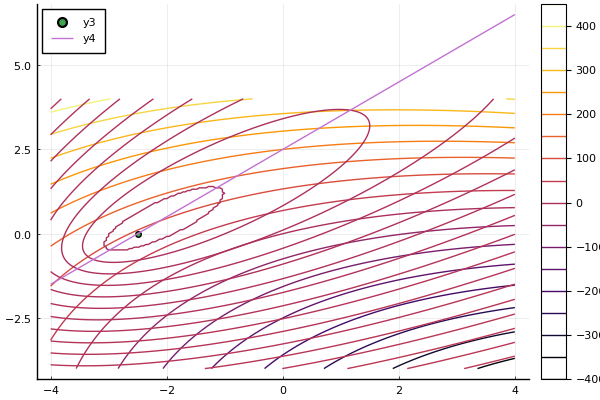

In [135]:
xrange = -4:0.04:4
yrange = -4:0.04:4

f(x, y) = [x; y]' * (Q/2) * [x; y] + p' * [x; y]
g(x, y) = max(0, norm(AMat * [x; y] - bVec, 2) - cVec' * [x; y] + dVal)
h(x) = m * x + b

contour(xrange, yrange, f)
contour!(xrange, yrange, g)
scatter!([evaluate(x)[1]], [evaluate(x)[2]])
plot!(xrange, h)